# Generating Mood Playlists: Pre-processing and Clustering

In [1]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# allowing all the columns to be visualized
pd.options.display.max_columns = None

# rendering all graphics straight out of the notebook
%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

In [2]:
# visualizations settings
sns.set_theme(style = "whitegrid", font_scale = 1.5)
qual_pal = sns.color_palette('hls', 8)

In [3]:
# data import
audio_features = pd.read_csv("/Users/huongngo/Desktop/PERSONAL PROJECTS/music_explorer/data/audio_features.csv")

## Pre-processing + Feature Engineering

In terms checking for multicollinearity, we're going to use 0.7/0.8 as our cutoff. 

- Energy and loudness have a high correlation of 0.8
- Energy and acousticness have a high correlation of -0.78

Thus, we will be dropping both loudness and acousticness since they're also both not useful to determining mood classes. 

We'll also be dropping liveness and duration because they have too many outliers. 

Since explicit has a lot of 'False', it seems that it won't add much to figuring out mood classes. 

Although instrumentalness and speechiness don't have much correlation with each other, we'll be dropping both of them as they have too many outliers. 

Columns we'll be keeping: danceability, energy, mode, valence, tempo, time_signature, key. 

### Potential Transformations

- We will have to one-hot encode the mode feature. 
- We'll have to standardize the other numerical features

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [5]:
audio_features_ml = audio_features[['danceability', 'energy', 'mode', 'valence', 'tempo', 'key']]

In [6]:
# encoding and scaling features
enc = OneHotEncoder()
encoded_cols = enc.fit_transform(audio_features_ml[['mode']]).toarray()
print(enc.categories_)
enc_df = pd.DataFrame(encoded_cols, columns = ['mode_minor', 'mode_major'])
enc_df.head()

[array([0, 1])]


,mode_minor,mode_major
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [7]:
audio_features_ml = audio_features_ml.merge(enc_df, left_index = True, right_index = True) \
    .drop(['mode'], axis = 1)
audio_features_ml.head()

,danceability,energy,valence,tempo,key,mode_minor,mode_major
0,0.492,0.791,0.585,144.363,11,0.0,1.0
1,0.278,0.354,0.090,121.803,5,1.0,0.0
2,0.509,0.457,0.521,116.472,6,0.0,1.0
3,0.401,0.712,0.561,84.343,8,0.0,1.0
4,0.506,0.612,0.527,139.931,11,0.0,1.0


In [8]:
numeric_columns = ['danceability', 'energy', 'valence', 'tempo']
cat_columns = ['time_signature', 'mode_minor', 'mode_major']

In [9]:
scaler = StandardScaler()
scaled_cols = pd.DataFrame(scaler.fit_transform(audio_features_ml[numeric_columns]))
audio_features_ml[numeric_columns] = scaled_cols
audio_features_ml.head()

,danceability,energy,valence,tempo,key,mode_minor,mode_major
0,-0.297043,0.745460,0.501400,0.835963,11,0.0,1.0
1,-1.477316,-0.902766,-1.423987,0.097770,5,1.0,0.0
2,-0.203283,-0.514282,0.252461,-0.076667,6,0.0,1.0
3,-0.798935,0.447497,0.408048,-1.127971,8,0.0,1.0
4,-0.219829,0.070329,0.275799,0.690942,11,0.0,1.0


## Clustering - Gaussian Mixture Models to Find Mood Structure

### Types of Clustering
https://developers.google.com/machine-learning/clustering/clustering-algorithms 

### Gaussian Mixture Models (GMM)
https://aabkn.github.io/GMM_visually_explained 

#### Motivation
K-means clustering isn't flexible enough to account for non-spherical clusters and tries to force-fit data into them. This results in a mixing of cluster assignments where the resulting clusters overlap. 

It's also a hard clustering method–the distance between the centroid and the most distant point of the cluster acts as a hard cutoff for cluster assignment. 

It can't measure probability or uncertainty of a cluster assignment. 

#### What is GMM?
It is a clustering technique that attempts to find a mixture of Gaussian probability distributions that best model any input dataset. It assumes that data is composed of different Gaussian distributions. 

It employs the expectation-maximization (EM) algorithm to cluster points and assign probabilities of belonging to a cluster to each point:
1. Choose start guesses for location and shape
2. Repeat until converged:
    1. E-step: For each observation, find weights encoding probability of membership in each cluster
    2. M-step: For each cluster, update its parameters (mean, variance, mixture parameter) making use of the weights (probability of membership). This is updated in order to take steps to maximize the likelihood of the points belonging to the cluster. 

##### What is the Expectation-Maximization (EM) Algorithm?

If we know which component a point came from (class label), we can learn the parameters of each component independently. On the other hand, if we know the parameters of all components, we can assign points to their most probable class. 

This leads us to the idea that we can iteratively update the parameters and class labels based on previous estimates of them. 

The EM algorithm does exactly that except it uses probabilities of a point belonging to a cluster. 

There are 2 main components that make up the EM algorithm. The expectation component calculates the posterior probability that a point belongs to cluster k given the cluster is a Gaussian distribution with a set of parameters.

The maximization component first involves taking the expected value of the log-likelihood given the posterior distribution of the cluster assignments. This is because in GMM, uncertainty is accounted for when doing cluster assignments and thus there is randomness in cluster assignments. To estimate the log-likelihood, we take the expectation of it and then maximize on it to find the best parameters that fit the Gaussian mixture distribution and can thus best model the data. 

#### Assumptions
- The data is assumed to be of a Gaussian mixture distrbution
- The observations in the data are independent

### Finding the right number of clusters - Bayesian Information Criterion (BIC)


In [10]:
from sklearn.mixture import GaussianMixture

In [11]:
n_clusters = list(range(2, 11))
bic_score = []
for n in n_clusters:
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    model = gmm_model.fit(audio_features_ml)
    bic_score.append(model.bic(audio_features_ml))

/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_80042/2131860362.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2, 11), bic_score, 'bo-', alpha = 1, color = 'black')


Text(0, 0.5, 'Score')

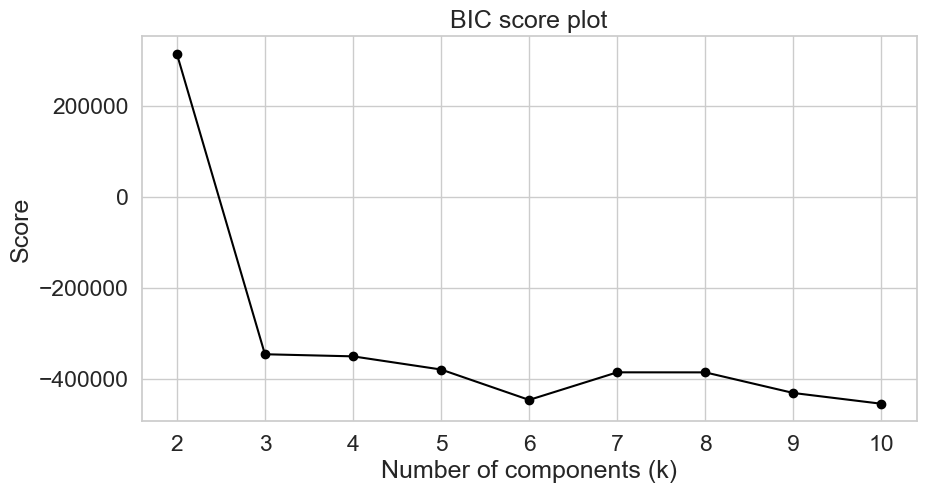

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 11), bic_score, 'bo-', alpha = 1, color = 'black')
plt.title('BIC score plot')
plt.xlabel('Number of components (k)')
plt.ylabel('Score')

### Building the model for 6 clusters

In [13]:
gmm_model_6 = GaussianMixture(6, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels = gmm_model_6.fit_predict(audio_features_ml)

In [32]:
audio_features_ml['cluster'] = labels + 1
audio_features_ml['mode'] = audio_features['mode']
audio_features_ml['genre'] = audio_features['genre']
audio_features_ml.head()

,danceability,energy,valence,tempo,key,mode_minor,mode_major,cluster,mode,genre
0,-0.297043,0.745460,0.501400,0.835963,11,0.0,1.0,2,1,jazz
1,-1.477316,-0.902766,-1.423987,0.097770,5,1.0,0.0,4,0,jazz
2,-0.203283,-0.514282,0.252461,-0.076667,6,0.0,1.0,3,1,jazz
3,-0.798935,0.447497,0.408048,-1.127971,8,0.0,1.0,5,1,jazz
4,-0.219829,0.070329,0.275799,0.690942,11,0.0,1.0,2,1,jazz


In [33]:
clusters = audio_features_ml.groupby(['cluster'])
clusters.size().sort_values(ascending = False)

cluster
4    19086
5     9967
3     9255
6     7570
1     5134
2     1885
dtype: int64

/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.a

<AxesSubplot: >

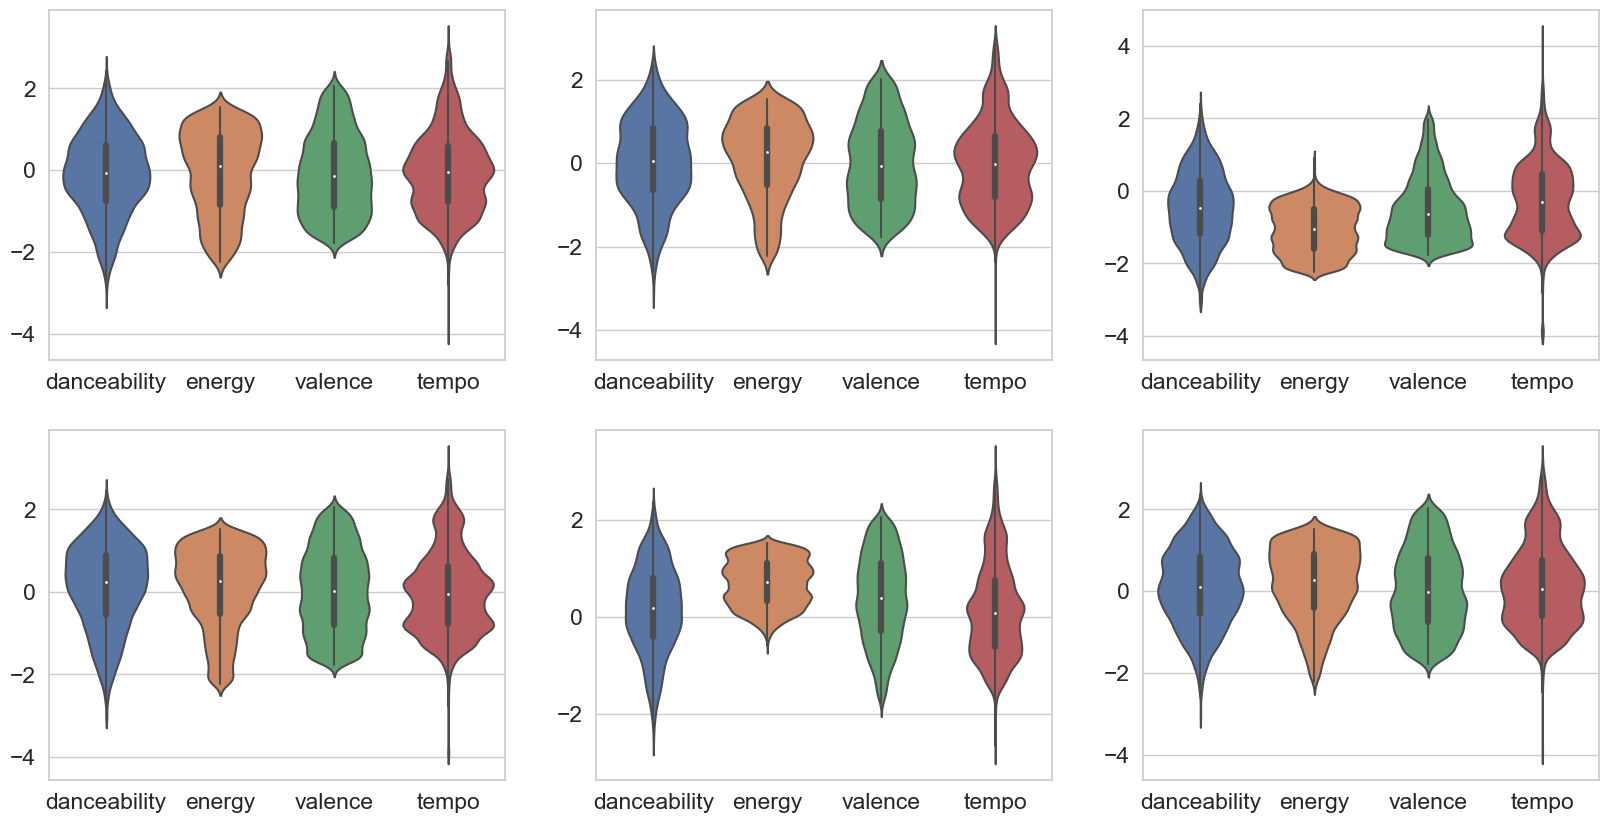

In [40]:
fig, axes = plt.subplots(2, 3, figsize = (20, 10))
sns.violinplot(ax = axes[0, 0], data = clusters.get_group(1)[numeric_columns])
sns.violinplot(ax = axes[0, 1], data = clusters.get_group(2)[numeric_columns])
sns.violinplot(ax = axes[0, 2], data = clusters.get_group(3)[numeric_columns])
sns.violinplot(ax = axes[1, 0], data = clusters.get_group(4)[numeric_columns])
sns.violinplot(ax = axes[1, 1], data = clusters.get_group(5)[numeric_columns])
sns.violinplot(ax = axes[1, 2], data = clusters.get_group(6)[numeric_columns])